#Persiapan data

In [43]:
# Impor pustaka-pustaka yang diperlukan
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, roc_curve, auc
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import cross_val_score, KFold
from sklearn.impute import SimpleImputer
from sklearn.model_selection import GridSearchCV

# Baca dataset
data = pd.read_csv("drive/MyDrive/loan_data_2007_2014.csv")

<ipython-input-43-6afbeb2c5053>:16: DtypeWarning: Columns (20) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv("drive/MyDrive/loan_data_2007_2014.csv")


#Pemahaman dan Eksplorasi Data

In [44]:
print(data.info())
print(data.describe())
print(data['loan_status'].value_counts())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 466285 entries, 0 to 466284
Data columns (total 75 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   Unnamed: 0                   466285 non-null  int64  
 1   id                           466285 non-null  int64  
 2   member_id                    466285 non-null  int64  
 3   loan_amnt                    466285 non-null  int64  
 4   funded_amnt                  466285 non-null  int64  
 5   funded_amnt_inv              466285 non-null  float64
 6   term                         466285 non-null  object 
 7   int_rate                     466285 non-null  float64
 8   installment                  466285 non-null  float64
 9   grade                        466285 non-null  object 
 10  sub_grade                    466285 non-null  object 
 11  emp_title                    438697 non-null  object 
 12  emp_length                   445277 non-null  object 
 13 

In [45]:
# Membuat fungsi untuk mengkategorikan loan_status
def categorize_loan_status(status):
    if status in ['Charged Off', 'Default', 'Late (31-120 days)', 'In Grace Period', 'Late (16-30 days)',
                  'Does not meet the credit policy. Status:Charged Off']:
        return 0  # resiko
    else:
        return 1  # aman

# Menerapkan fungsi ke kolom 'loan_status'
data['loan_status'] = data['loan_status'].apply(categorize_loan_status)

In [46]:
data['loan_status']

0         1
1         0
2         1
3         1
4         1
         ..
466280    1
466281    0
466282    1
466283    1
466284    1
Name: loan_status, Length: 466285, dtype: int64

In [49]:
print("shape sebelum data dibersihkan = ", data.shape)

shape sebelum data dibersihkan =  (466285, 75)


#Eksplorasi Data dengan Visualisasi

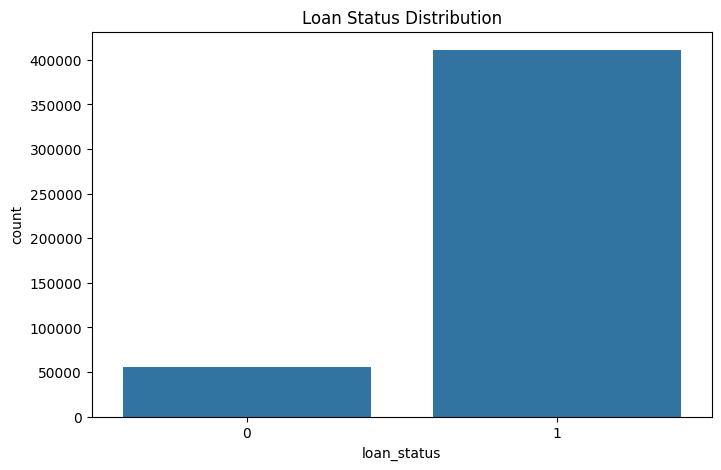

In [5]:
# Countplot untuk melihat distribusi 'loan_status'
plt.figure(figsize=(8, 5))
sns.countplot(x='loan_status', data=data)
plt.title('Loan Status Distribution')
plt.show()

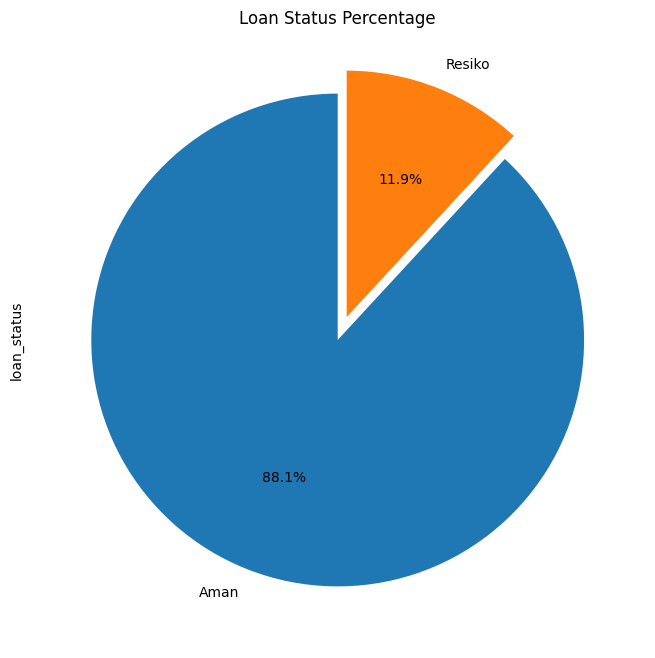

In [7]:
# Pie chart untuk visualisasi persentase 'loan_status'
plt.figure(figsize=(8, 8))
data['loan_status'].value_counts().plot.pie(autopct='%1.1f%%', startangle=90, explode=[0, 0.1], labels=['Aman', 'Resiko'])
plt.title('Loan Status Percentage')
plt.show()

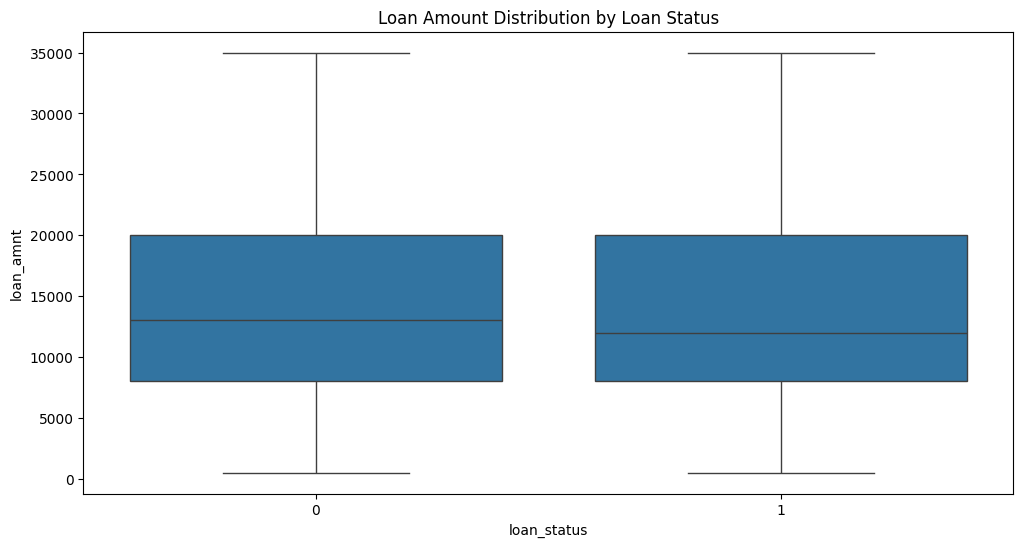

In [8]:
# Boxplot untuk melihat distribusi 'loan_amnt' terhadap 'loan_status'
plt.figure(figsize=(12, 6))
sns.boxplot(x='loan_status', y='loan_amnt', data=data)
plt.title('Loan Amount Distribution by Loan Status')
plt.show()

/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


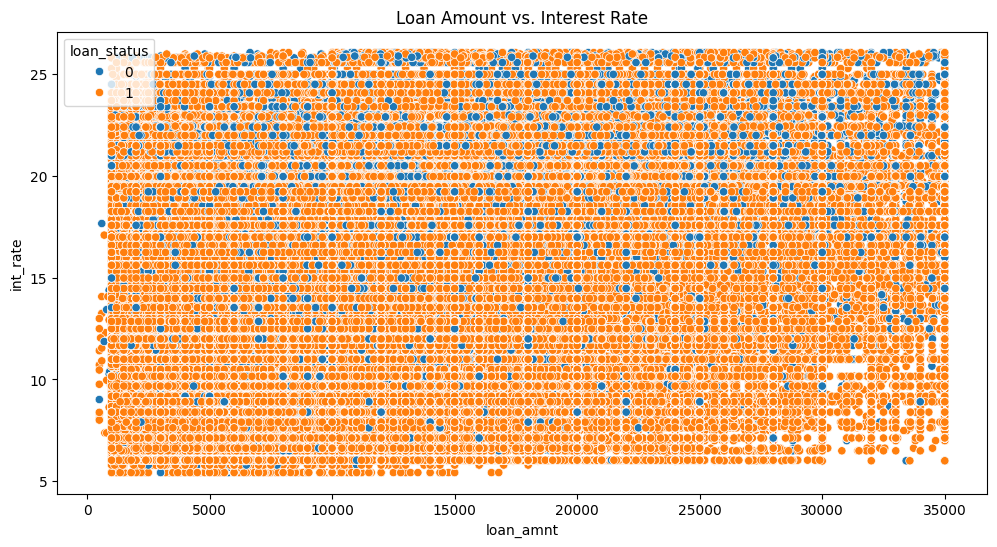

In [9]:
# Plot sebaran (scatter plot) untuk melihat hubungan antara 'loan_amnt' dan 'int_rate'
plt.figure(figsize=(12, 6))
sns.scatterplot(x='loan_amnt', y='int_rate', hue='loan_status', data=data)
plt.title('Loan Amount vs. Interest Rate')
plt.show()

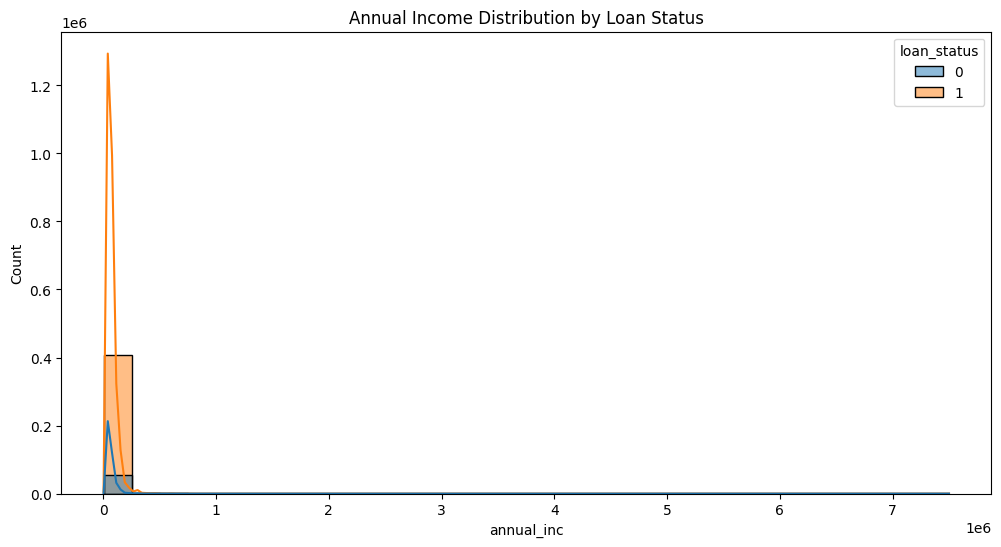

In [10]:
# Histogram untuk melihat distribusi 'annual_inc' terhadap 'loan_status'
plt.figure(figsize=(12, 6))
sns.histplot(data=data, x='annual_inc', hue='loan_status', bins=30, kde=True)
plt.title('Annual Income Distribution by Loan Status')
plt.show()

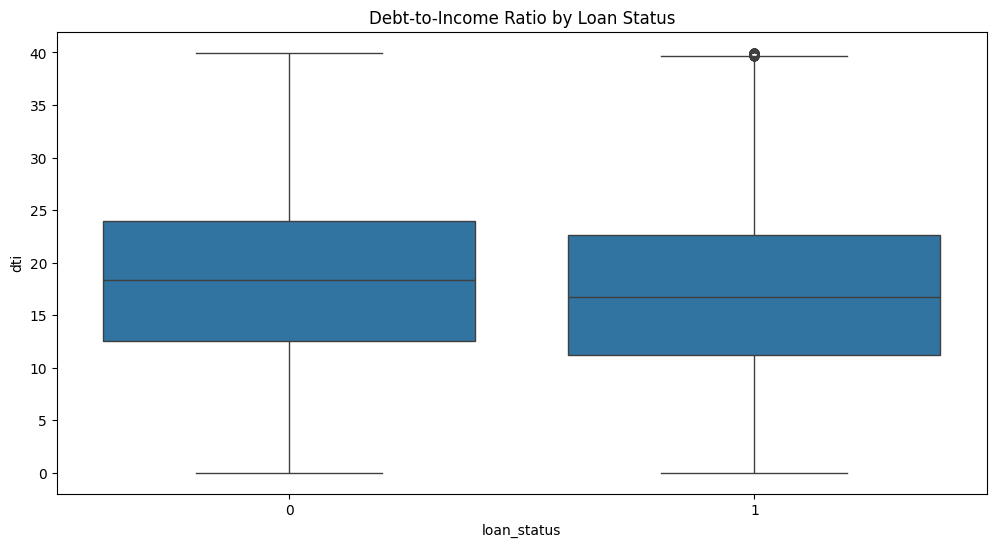

In [11]:
# Boxplot untuk melihat distribusi 'dti' terhadap 'loan_status'
plt.figure(figsize=(12, 6))
sns.boxplot(x='loan_status', y='dti', data=data)
plt.title('Debt-to-Income Ratio by Loan Status')
plt.show()

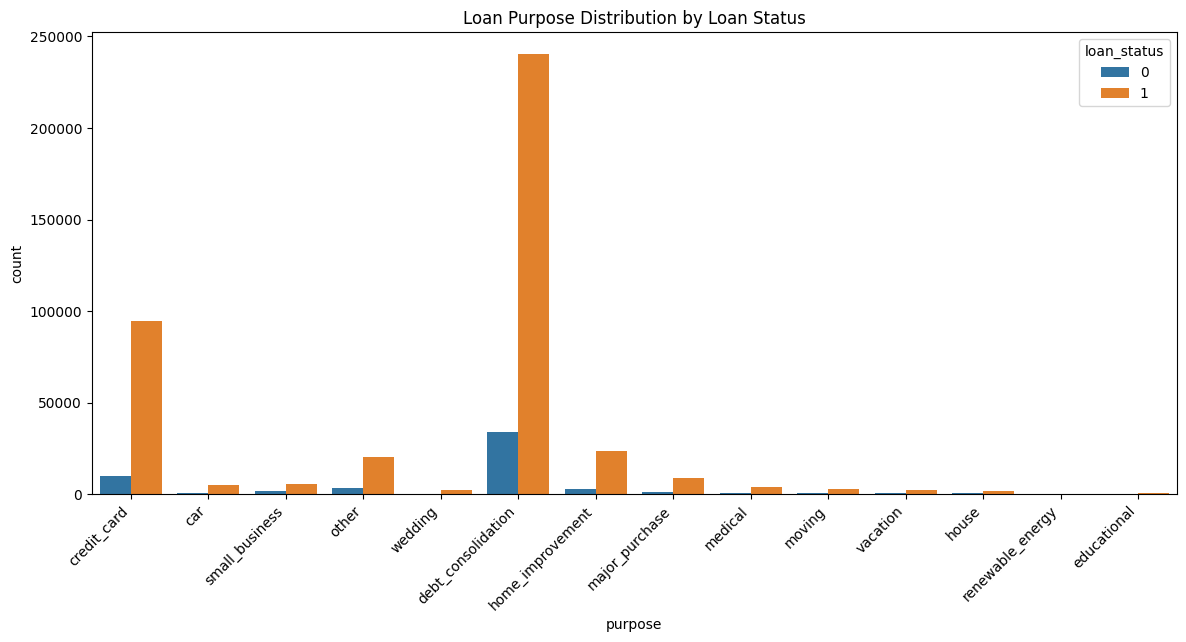

In [12]:
# Countplot untuk melihat distribusi 'purpose' terhadap 'loan_status'
plt.figure(figsize=(14, 6))
sns.countplot(x='purpose', hue='loan_status', data=data)
plt.title('Loan Purpose Distribution by Loan Status')
plt.xticks(rotation=45, ha='right')
plt.show()


#Preprocessing Data

In [51]:
# Membersihkan Data Nilai yang Hilang, Duplikat, Data Outlier, dan pengkodean
data.drop(['url', 'desc'], axis=1, inplace=True)  # Drop kolom URL dan desc
data.drop_duplicates(inplace=True)  # Hapus data duplikat

In [52]:
# Pilih subset fitur yang paling relevan
selected_features = ['loan_amnt', 'term', 'int_rate', 'installment', 'grade', 'emp_length', 'home_ownership',
                     'annual_inc', 'verification_status', 'purpose', 'dti', 'delinq_2yrs', 'inq_last_6mths',
                     'open_acc', 'pub_rec', 'revol_bal', 'revol_util', 'total_acc', 'loan_status']

data = data[selected_features]

#Model Building

In [53]:
# One-hot encoding untuk variabel kategori
data = pd.get_dummies(data, columns=['term', 'grade', 'emp_length', 'home_ownership', 'verification_status', 'purpose'])

In [54]:
# Pisahkan variabel target dan fitur
X = data.drop('loan_status', axis=1)
y = data['loan_status']

In [55]:
# Identifikasi dan tangani nilai NaN dalam dataset
nan_columns = X.columns[X.isna().any()].tolist()

In [56]:
# Imputasi nilai NaN dengan SimpleImputer
imputer = SimpleImputer(strategy='mean')  # Ganti 'mean' dengan metode imputasi yang sesuai
X[nan_columns] = imputer.fit_transform(X[nan_columns])

In [57]:
# Ganti nilai NaN yang mungkin tersisa dengan nilai tertentu
X = X.fillna(-9999)  # Ganti -9999 dengan nilai yang sesuai


In [58]:
# Resampling menggunakan SMOTE setelah menangani nilai NaN
smote = SMOTE(random_state=42)
X_resampled_smote, y_resampled_smote = smote.fit_resample(X, y)

In [59]:
# Bagilah dataset menjadi data pelatihan dan data pengujian setelah pemrosesan nilai NaN
X_train, X_test, y_train, y_test = train_test_split(X_resampled_smote, y_resampled_smote, test_size=0.2, random_state=42)

In [60]:
# Normalisasi fitur menggunakan StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [61]:
print("shape sesudah data dibersihkan", data.shape)

shape sesudah data dibersihkan (466285, 56)


#Pelatihan Model

In [24]:
# Pilih model pembelajaran mesin yang sesuai
model = RandomForestClassifier(random_state=42)

In [25]:
# Latih model dengan data pelatihan
model.fit(X_train_scaled, y_train)

RandomForestClassifier(random_state=42)

#Evaluasi Model

In [26]:
# Evaluasi kinerja model menggunakan metrik evaluasi yang relevan
y_pred = model.predict(X_test_scaled)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_pred))

Accuracy: 0.9313915148860581
Precision: 0.8806406372113439
Recall: 0.9984342189908602
F1 Score: 0.9358453644606756
ROC AUC: 0.9312312566995279


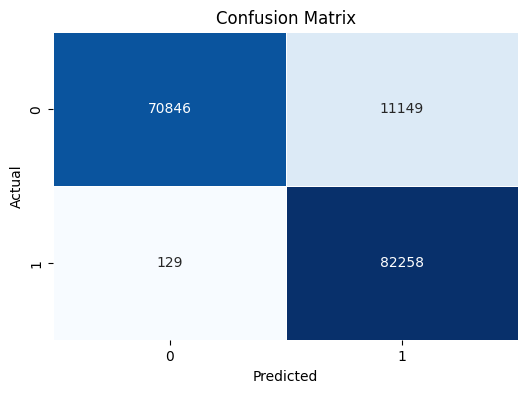

In [27]:
# Visualisasi Matriks Konfusi
plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues', linewidths=.5, cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

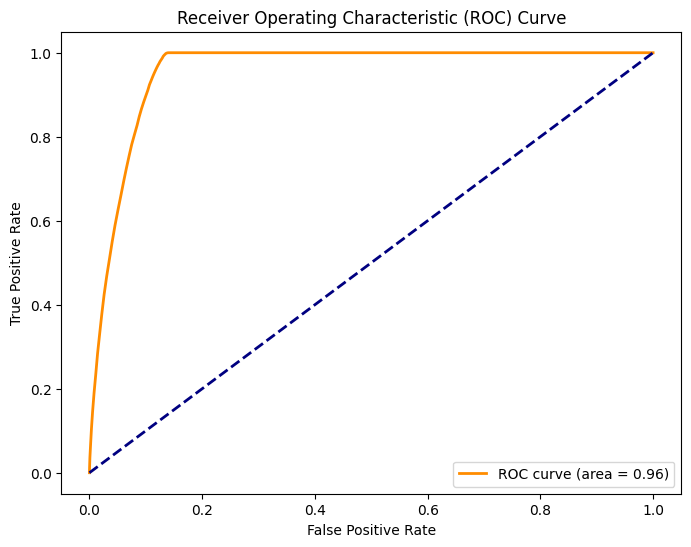

In [28]:
# Visualisasi Kurva ROC
fpr, tpr, thresholds = roc_curve(y_test, model.predict_proba(X_test_scaled)[:, 1])
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()